<a href="https://colab.research.google.com/github/javieryw/Location_Capstone/blob/main/The_Battle_of_the_Neighborhood_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of contents
* [1. Business Problem and Background](#introduction)
* [2. Data Required](#data)
* [3. Data Processing](#processing)
* [4. Methodology](#methodology)
* [5. Results and Discussion](#result)
* [6. Conclusion](#conclusion)

# 1. Business Problem and Background <a name='introduction'></a>

Deciding on a new neighbourhood to move to in different stages of life has never been a decison. In addition to convenience, there are many other criterias in which one would look for, for example the similarity in the environment compared to the current neighborhood. In a small country like Singapore, the differences between the neighborhood might be too subtle to be noticed and that makes the searching process even more lengthy.

In this project, we will try to group and cluster neighborhoods within Singapore based on similarity in terms of nearby venues within each neighborhood to explore how different the neighbourhoods in Singapore really are.

This report will used to group and clusters different neighborhoods within Singapore to help home seekers narrow down potential neighborhoods that are similar to where they are currently living in and assist property agents to make better proposals to their clients.

# 2. Data Required <a name='data'></a>

The data involved would the entire list of neighborhood present in Singapore, which will be extracted from a Wikipedia page and scraped using the BeautifulSoup Library. 


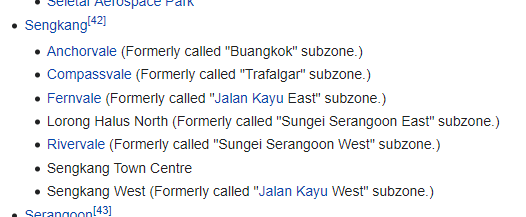


The OpenCage Geocoder API will then be used to retrieve the latitude and longitude of each neighborhood, which will then be used to call the Foursquare API to analyse the neighborhoods by looking and comparing the similarities in terms of the venues nearby each neighborhood using the explore endpoint of the Foursquare API.
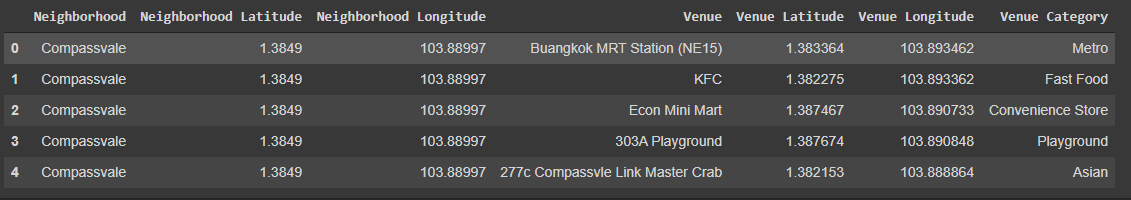

Finally, k-means clustering technique will be utilised to cluster the neighborhoods together based on the similarity in terms of venues within the neighborhood and each cluster will be displayed separately.



# 3. Data Processing <a name='processing'></a>

We will first retrieve all the neighbourhoods in Singapore from <a href="https://en.wikipedia.org/wiki/List_of_places_in_Singapore">Wikipedia</a> and pass it through BeautifulSoup to extract all the neighborhoods.

In [ ]:
#@title
import pandas as pd
import numpy as np
import geocoder
import requests
from bs4 import BeautifulSoup

In [ ]:
#@title
r = requests.get('https://en.wikipedia.org/wiki/List_of_places_in_Singapore')
content = r.content
soup = BeautifulSoup(content)

neighbourhood_list = []
div = soup.findAll('div')

for row in div:
  try:
    if(row['aria-labelledby'] == "Places_in_Singapore_by_region"):
      for each in row.findAll('li'):
        if (len(each.text) != 1):
          neighbourhoods = each.text.split('\n')
          for neighbourhood in neighbourhoods:
            if neighbourhood not in neighbourhood_list:
              neighbourhood_list.append(neighbourhood)
  except:
    pass

With a list of all existing neighbourhood in Singapore, we will make use of the OpenCage Geocoding API to retrieve the latitude and longitude of each neighbourhood and put them into a data frame.

In [ ]:
table_content = []
for neighbourhood in neighbourhood_list:
  search = f'{neighbourhood}, Singapore'

  url = "https://api.opencagedata.com/geocode/v1/json?q={}&key=6ef78c219b1b4a5ba8b3e61b4e4837be".format(search)

  results = requests.get(url).json()['results'][0]['geometry']
  table_content.append(
      {
          "Neighborhood": neighbourhood,
          "Latitude": results['lat'],
          "Longitude": results['lng']
      }
  )

df = pd.DataFrame(table_content)
df.head()

,Neighborhood,Latitude,Longitude
0,Bishan,1.350986,103.848255
1,Marymount,1.348604,103.839393
2,Upper Thomson,1.354498,103.832821
3,Bukit Merah,1.270439,103.828318
4,Alexandra,1.277477,103.801880


With the information of all the neighbourhood, we will now call the FourSquare API for each neighbout using a function to retrieve all nearby venues and relevant information of each venues (Name, lat, long and category) and put it into a separate data frame.

In [ ]:
#@title
CLIENT_ID = 'your-R3QC41WWQHWWK1BP0V32NEO25YSG20KEVACVZ1UFOISKJ4I2-ID' 
CLIENT_SECRET = 'WIVNA1TZDSVE5CZWUTAM2K1JTVOJTG0TW5FHLFGLD1ZOPIDW-client-secret'
ACCESS_TOKEN = 'BOB3HGO3L2UZLBYBZZCWA0UIITOOLKN12UHTSLX0WXGR12SD'
VERSION = '20180605' 
LIMIT = 100 

def getNearbyVenues(names, latitudes, longitudes, radius=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&oauth_token={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            ACCESS_TOKEN,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

nearby_venues = getNearbyVenues(names=df['Neighborhood'],
                                  latitudes=df['Latitude'],
                                  longitudes=df['Longitude'])

nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bishan,1.350986,103.848255,Tori-Q,1.350549,103.848659,Japanese Restaurant
1,Bishan,1.350986,103.848255,Popular Bookstore,1.350677,103.848718,Bookstore
2,Bishan,1.350986,103.848255,Din Tai Fung 鼎泰豐,1.351006,103.848247,Dumpling Restaurant
3,Bishan,1.350986,103.848255,Pet Lovers Centre,1.350872,103.848224,Pet Store
4,Bishan,1.350986,103.848255,Ya Kun Kaya Toast 亞坤,1.350515,103.848671,Coffee Shop


Now that we have the nearby venues of each neighbourhood, we will now combine the nearby venues together with the neighbourhood data frame with the nearby venues as the column header and how common is it within the neighbourhood as its value.

In [ ]:
# one hot encoding
neighbourhood_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

neighbourhood_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 
fixed_columns = [neighbourhood_onehot.columns[-1]] + list(neighbourhood_onehot.columns[:-1])
neighbourhood_onehot = neighbourhood_onehot[fixed_columns]

neighbourhood_grouped = neighbourhood_onehot.groupby('Neighborhood').mean().reset_index()

neighbourhood_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,...,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Taxi,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant
0,Admiralty,0.0,0.068966,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.137931,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.034483,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.034483,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Airport,0.0,0.000000,0.0,0.052632,0.026316,0.184211,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.000000,0.0,...,0.0,0.026316,0.026316,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alexandra,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aljunied,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.055556,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Anchorvale,0.0,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For easier visualisation of the nearby venues in each neighbourhood, we will create a function to get the top 10 common nearby venues for each neighbourhood and display them in a data frame

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighbourhood_grouped['Neighborhood']

for ind in np.arange(neighbourhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighbourhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Bakery,ATM,Food Court,Bubble Tea Shop,Breakfast Spot,Burger Joint,Supermarket,Food Truck,Metro Station,Snack Place
1,Airport,Airport Lounge,Coffee Shop,Donut Shop,Chinese Restaurant,Café,Snack Place,Airport,Bookstore,Restaurant,Clothing Store
2,Alexandra,Food Court,Bus Station,Smoke Shop,Food,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
3,Aljunied,Chinese Restaurant,Pharmacy,Vegetarian / Vegan Restaurant,Restaurant,Train Station,Café,Steakhouse,Food Court,Snack Place,Plaza
4,Anchorvale,Jewelry Store,Airport,Pizza Place,Park,Xinjiang Restaurant,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space


# 4. Methodology <a name='methodology'></a>


Now that we finally have all the data we require, we will now pass all the data into a k-means clustering algorithm to group and cluster the neighbourhoods together based on their similarities in terms of the commonality of their nearby venues.

In [ ]:
#@title
import json 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [ ]:
#@title
# set number of clusters
kclusters = 7

neighbourhood_grouped_clustering = neighbourhood_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(neighbourhood_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighbourhood_merged = df
neighbourhood_merged = neighbourhood_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# neighbourhood_merged = neighbourhood_merged.astype({"Cluster Labels": int})
neighbourhood_merged = neighbourhood_merged.fillna(0)
neighbourhood_merged['Cluster Labels'] = neighbourhood_merged['Cluster Labels'].astype(int)

neighbourhood_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bishan,1.350986,103.848255,5,Cosmetics Shop,Bakery,Jewelry Store,Shoe Store,Japanese Restaurant,Bubble Tea Shop,Women's Store,Chinese Restaurant,Gift Shop,Electronics Store
1,Marymount,1.348604,103.839393,0,Metro Station,Playground,Outdoors & Recreation,Xinjiang Restaurant,Event Space,Drugstore,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant
2,Upper Thomson,1.354498,103.832821,2,Bus Stop,Xinjiang Restaurant,Cosmetics Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
3,Bukit Merah,1.270439,103.828318,0,Cafeteria,Business Service,Bus Station,Xinjiang Restaurant,Food & Drink Shop,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
4,Alexandra,1.277477,103.801880,1,Food Court,Bus Station,Smoke Shop,Food,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit


Lets create a map and colour code the different clusters of neighbourhood for easier visualisation.

In [ ]:
# create map
map_clusters = folium.Map(location=[1.290270, 103.851959], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbourhood_merged['Latitude'], neighbourhood_merged['Longitude'], neighbourhood_merged['Neighborhood'], neighbourhood_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
cluster1 = neighbourhood_merged[neighbourhood_merged['Cluster Labels'] == 1]
cluster1

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Alexandra,1.277477,103.801880,1,Food Court,Bus Station,Smoke Shop,Food,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
21,Geylang,1.318186,103.887056,1,Bus Station,Smoke Shop,Xinjiang Restaurant,Cosmetics Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
23,Geylang East,1.318186,103.887056,1,Bus Station,Smoke Shop,Xinjiang Restaurant,Cosmetics Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
89,Loyang,1.375368,103.977292,1,Bus Station,Xinjiang Restaurant,Cosmetics Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
160,Chin Bee,1.334714,103.718551,1,Gaming Cafe,Bus Station,Food & Drink Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Xinjiang Restaurant


In [ ]:
cluster2 = neighbourhood_merged[neighbourhood_merged['Cluster Labels'] == 2]
cluster2

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Upper Thomson,1.354498,103.832821,2,Bus Stop,Xinjiang Restaurant,Cosmetics Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
12,Holland Road,1.309824,103.806464,2,Bus Stop,Xinjiang Restaurant,Cosmetics Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
37,Marina South,1.276998,103.861500,2,Bus Stop,Xinjiang Restaurant,Cosmetics Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
169,Gul Circle,1.319635,103.660655,2,Bus Stop,Train Station,Xinjiang Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit


In [ ]:
cluster3 = neighbourhood_merged[neighbourhood_merged['Cluster Labels'] == 3]
cluster3

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Bidadari,1.338466,103.874898,3,Food Court,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Xinjiang Restaurant
78,Joo Seng,1.335530,103.883321,3,Food Court,Sandwich Place,Bakery,Café,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Donut Shop


In [ ]:
cluster4 = neighbourhood_merged[neighbourhood_merged['Cluster Labels'] == 4]
cluster4

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Tanjong Rhu,1.297343,103.873764,4,Café,Cosmetics Shop,Drugstore,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Xinjiang Restaurant
84,Siglap,1.317699,103.918570,4,Café,Cosmetics Shop,Drugstore,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Xinjiang Restaurant
153,Jurong Port,1.305630,103.721251,4,Café,Cosmetics Shop,Drugstore,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Xinjiang Restaurant


In [ ]:
cluster5 = neighbourhood_merged[neighbourhood_merged['Cluster Labels'] == 5]
cluster5

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bishan,1.350986,103.848255,5,Cosmetics Shop,Bakery,Jewelry Store,Shoe Store,Japanese Restaurant,Bubble Tea Shop,Women's Store,Chinese Restaurant,Gift Shop,Electronics Store
6,Depot Road,1.280372,103.816986,5,Hobby Shop,Donut Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Xinjiang Restaurant
7,HarbourFront,1.265536,103.822766,5,Japanese Restaurant,Cosmetics Shop,Jewelry Store,Snack Place,Dessert Shop,Bubble Tea Shop,Korean Restaurant,Bakery,Light Rail Station,Music Store
10,Tiong Bahru,1.286179,103.827225,5,Bakery,Coffee Shop,Chinese Restaurant,Sushi Restaurant,Pharmacy,Fast Food Restaurant,Women's Store,Snack Place,Optical Shop,Cosmetics Shop
11,Bukit Timah,1.354690,103.776372,5,Rest Area,Trail,Scenic Lookout,Fish & Chips Shop,Escape Room,Dongbei Restaurant,Donut Shop,Drugstore,Flea Market,Dumpling Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,Taman Jurong,1.334884,103.720789,5,Food Court,Noodle House,Asian Restaurant,Food & Drink Shop,Vegetarian / Vegan Restaurant,Food,Shopping Mall,Supermarket,Sandwich Place,Bakery
165,Wenya,1.289670,103.850070,5,Coffee Shop,Café,Boat or Ferry,Asian Restaurant,Bike Rental / Bike Share,Bus Station,American Restaurant,Miscellaneous Shop,Indian Restaurant,Flea Market
166,Yunnan,1.338284,103.691089,5,Trail,Park,Xinjiang Restaurant,Event Space,Drugstore,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Exhibit
170,Joo Koon,1.327735,103.678222,5,Fast Food Restaurant,Bus Station,Coffee Shop,Thai Restaurant,Chinese Restaurant,Chinese Breakfast Place,Shopping Mall,Snack Place,Sporting Goods Shop,Martial Arts School


In [ ]:
cluster6 = neighbourhood_merged[neighbourhood_merged['Cluster Labels'] == 6]
cluster6

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
147,Faber,1.271924,103.817175,6,Scenic Lookout,Dongbei Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Xinjiang Restaurant


In [ ]:
cluster7 = neighbourhood_merged[neighbourhood_merged['Cluster Labels'] == 7]
cluster7

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


# 5. Results and Discussion <a name='result'></a>

As we can see in the map and tables above, majority of the the neighbourhood within Singapore fall within one cluster (5) while all the other clusters are relatively small compared to cluster 5. What we can derive from this result is that for people who are already living in onr of the neighbourhoods that is inside cluster 5, they do have plenty of options in terms of potential neighbourhood that are similar to where they are currently residing in. However, that is not to say that all the neighbourhoods are identical to each other as there are other variables such as pricing, distance from the venues or specific location (workplace, town area) which are not covered within the scope of this project.

People living in the other clusters on the other hand, would have a very small pool of options to choose from if they decide to move to another neighbourhood that is similar to where they are currently residing in. 

# 6. Conclusion <a name='conclusion'></a>

The purpose of this project is to group and cluster all the neighbourhoods within Singapore in order to aid people looking to move to another neighbourhood by narrowing down their options to a list of neighbourhoods that are relatively similar to where they are currently staying in now. By utilisating the OpenCage Geocoder and Foursquare API, we are able to retrieve all the nearby venues of each neighbourhood using their latitude and longitude information. Clustering of these neighbourhoods were then performed and the results were visualised in the form of a map and tables for each clusters respectively.

The final decision on which neighbourhood to move into would ultimately fall onto the home seekers themselves, keeping in mind that there are other additional factors to consider that are not covered within the scopes of this project. Some examples would include distance to key locations within the country such as town area, distance to their workplace and the price of houses within the area.